<h1 align="center">Volume 4: Total Variation.</h1>

    NAME Caelan Osman
    Section 1
    DATE Feb. 4, 2022

In [1]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt
from numpy.random import randint, uniform, randn
from matplotlib import cm
from imageio import imread, imwrite
import warnings
warnings.filterwarnings('ignore')

# Problem 1

Using 20 x steps, 250 time steps, and a final time of .2, plot the solution that
minimizes (17.4). It should match figure 17.1.

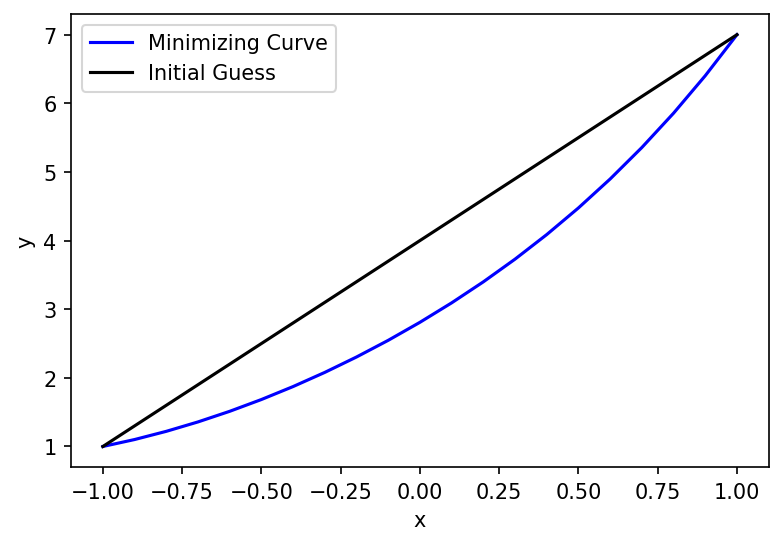

In [2]:
def problem1(a, b, alpha, beta, x_steps, time_steps, final_T):
    
    # Define variables x_steps, final_T, time_steps ####
    delta_t, delta_x = final_T/time_steps, (b-a)/x_steps
    x0 = np.linspace(a,b,x_steps+1)
    
    # Check a stability condition for this numerical method
    if delta_t/delta_x**2. > .5:
        print("stability condition fails")
    u = np.empty((2,x_steps+1))
    u[0] = (beta - alpha)/(b-a)*(x0-a) + alpha
    u[1] = (beta - alpha)/(b-a)*(x0-a) + alpha
    
    # save initial guess
    guess = u[0].copy()
    
    def rhs(y):
        # Approximate first and second derivatives to second order accuracy.
        yp = (np.roll(y,-1) - np.roll(y,1))/(2.*delta_x)
        ypp = (np.roll(y,-1) - 2.*y + np.roll(y,1))/delta_x**2.
        # Find approximation for the next time step, using a first order Euler step
        y[1:-1] -= delta_t*(1. + yp[1:-1]**2. - 1.*y[1:-1]*ypp[1:-1])
        
    # Time step until successive iterations are close
    iteration = 0
    while iteration < time_steps:
        rhs(u[1])
        if np.linalg.norm(np.abs((u[0] - u[1]))) < 1e-5: break
        u[0] = u[1]
        iteration+=1
        
    # now we plot    
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(x0, u[1], 'b-', label='Minimizing Curve')
    ax.plot(x0, guess, 'k-', label='Initial Guess')
    ax.legend(loc='best')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    
    return
problem1(-1, 1, 1, 7, 20, 250, 0.2)

# Problem 2

Using $\Delta$t = 1e−3, λ = 40, $\Delta$x = 1, and $\Delta$ y = 1, implement the numerical scheme
mentioned above to obtain a solution u. (So Ω = [0, nx] × [0, ny], where nx and ny represent
the number of pixels in the x and y dimensions, respectively.) Take 250 steps in time. Compare
your results with Figure 17.3.

In [3]:
def noisy_image(imagename):

    changed_pixels=40000
    # Read the image file imagename into an array of numbers, IM
    # Multiply by 1. / 255 to change the values so that they are floating point
    # numbers ranging from 0 to 1.
    IM = imread(imagename, as_gray=True) * (1. / 255)
    IM_x, IM_y = IM.shape
    for lost in range(changed_pixels):
        x_,y_ = randint(1,IM_x-2), randint(1,IM_y-2)
        val = .1*randn() + .5
        IM[x_,y_] = max( min(val,1.), 0.)
    imwrite("noised_"+imagename, IM)
    
    return
noisy_image('balloons_grey.jpg')

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


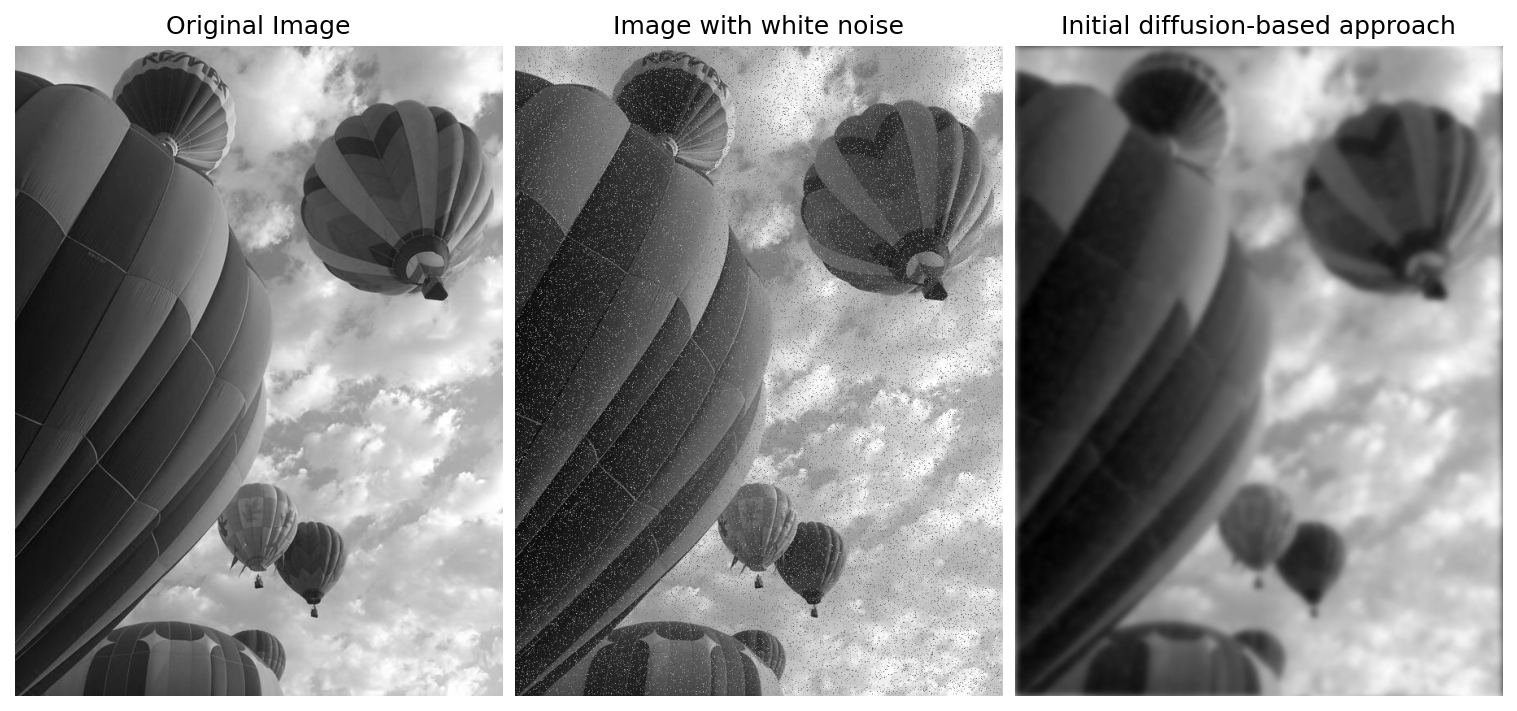

In [4]:
def diffusion(noised_image, Δt = 1e-3, λ=40., Δx = 1., Δy = 1., t_steps=250):
    
    # initialize variables
    f = imread(noised_image, as_gray=True)/255.
    u = f.copy()
    
    # run update
    for _ in range(t_steps):
        # calculate laplacian
        u_xx = (np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1))/(Δx**2)
        u_yy = (np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0))/(Δy**2)
        # update with forward Euler
        u +=  Δt*(f - u + λ*(u_xx + u_yy)) 
        
    return u

def problem2(original, noised_image):
    
    u = diffusion(noised_image)
    original = imread(original, as_gray=True)/255.
    f = imread(noised_image, as_gray=True)

    
    # plot
    fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(10, 10))
    fig.set_dpi(150)
    ax = axs[0]
    ax.axis('off')
    ax.set_title('Original Image')
    ax = ax.imshow(original, cmap='gray')
    ax = axs[1]
    ax.axis('off')
    ax.set_title('Image with white noise')
    ax.imshow(f, cmap='gray')
    ax = axs[2]
    ax.axis('off')
    ax.set_title('Initial diffusion-based approach')
    ax.imshow(u, cmap='gray')
    plt.show()
        
    return

problem2('balloons_grey.jpg', 'noised_balloons_grey.jpg')

# Problem 3

Using 4t = 1e − 3, λ = 1, 4x = 1, and 4y = 1, implement the numerical scheme
mentioned above to obtain a solution u. Take 200 steps in time. Compare your results with
Figure 17.3. How small should ε be?

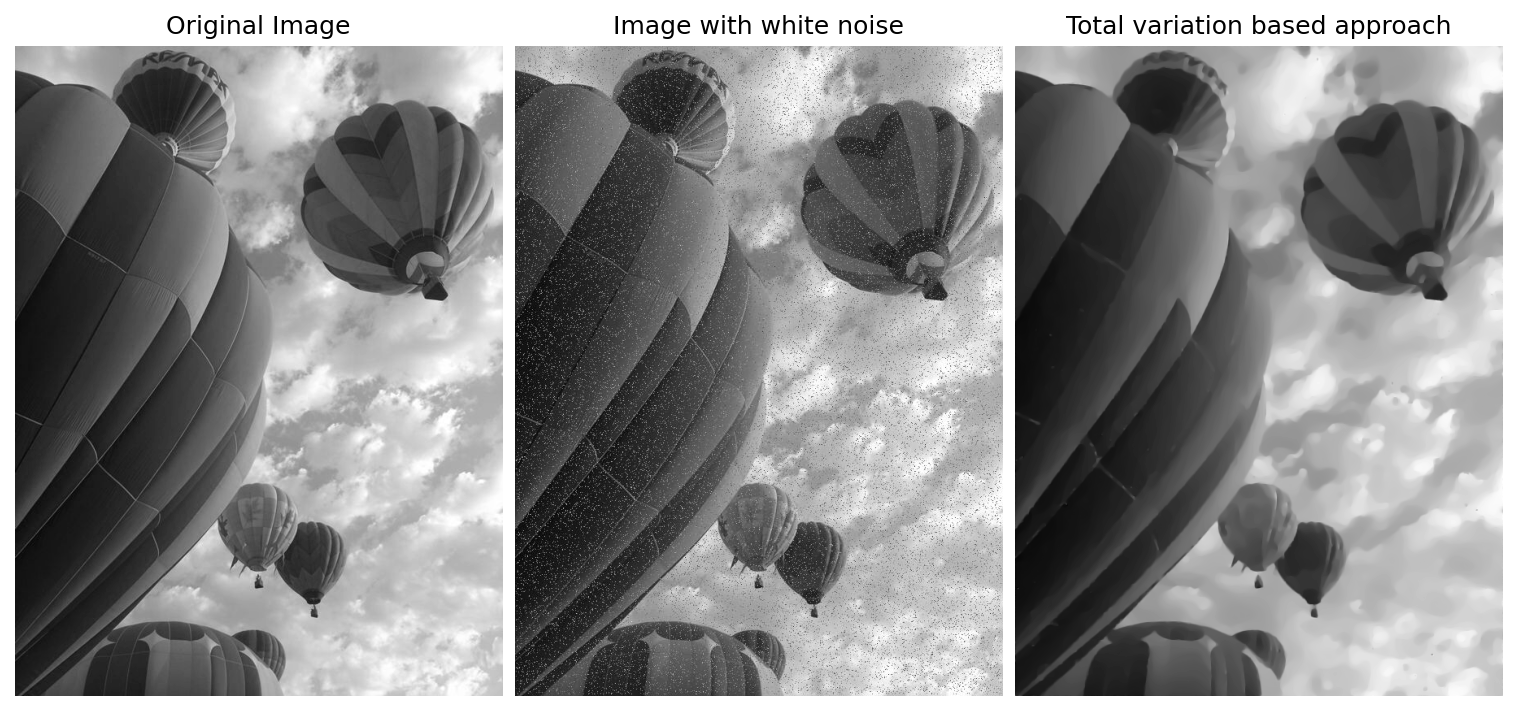

In [5]:
def total_variation(noised_image, Δt = 1e-3, λ=1., Δx = 1., Δy = 1., t_steps=200, ε= 1e-6):
    # read in image
    f = imread(noised_image, as_gray=True)/255.
    # copy
    u = f.copy()
    
    for _ in range(t_steps):
        # get derivatives
        u_x = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1))/(2*Δx)
        u_y = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0))/(2*Δy)
        u_xx = (np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1))/(Δx**2)
        u_yy = (np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0))/(Δy**2)
        u_xy = (np.roll(u_x, -1, axis=0) - np.roll(u_x , 1, axis=0))/2
        
        # now update image
        u += Δt*(λ*(f-u) + ((u_xx*(u_y**2) + u_yy*(u_x**2) - 2*u_x*u_y*u_xy)/(ε + u_x**2 + u_y**2)**(3/2)))
    
    return u

def problem3(original, noised_image):
    
    u = total_variation(noised_image)
    original = imread(original, as_gray=True)/255.
    f = imread(noised_image, as_gray=True)

    
    # plot
    fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(10, 10))
    fig.set_dpi(150)
    ax = axs[0]
    ax.axis('off')
    ax.set_title('Original Image')
    ax = ax.imshow(original, cmap='gray')
    ax = axs[1]
    ax.axis('off')
    ax.set_title('Image with white noise')
    ax.imshow(f, cmap='gray')
    ax = axs[2]
    ax.axis('off')
    ax.set_title('Total variation based approach')
    ax.imshow(u, cmap='gray')
    plt.show()
        
    return

problem3('balloons_grey.jpg', 'noised_balloons_grey.jpg')